In [1]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from IPython.display import Audio

## Audio preload

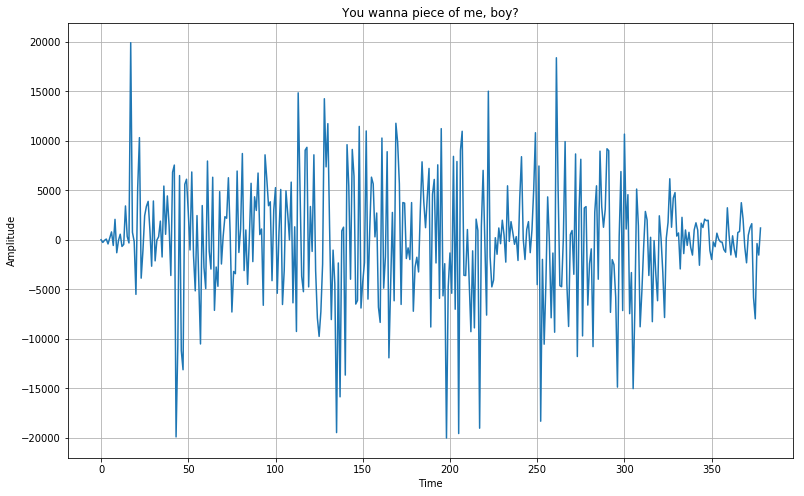

In [2]:
rate, audio = wav.read("lab - 10/TMaRdy00.wav")
k = 100

plt.figure(figsize=(13, 8))
plt.plot(audio[::k])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("You wanna piece of me, boy?")
plt.grid()
plt.show()

### Original audio

In [3]:
Audio(audio, rate=rate)

### Noised audio

In [5]:
audio_blurred = audio + np.random.normal(size=audio.shape) * 9e+3
Audio(audio_blurred, rate=rate)

## Filtering audio

In [6]:
def filter_audio(audio, T1=5, T2=44000, window=3, length=-1):
    
    filtered_audio = np.zeros(audio.shape)
    filtered_audio[:window] = audio[:window]
    
    if length == -1:
        length = len(audio)
    
    def window_handle(audio, c_x=-1, window=3):
        W = audio[c_x - window: c_x + window + 1]
        
        M_MEDIAN = np.median(W)
        M = np.max(np.abs(audio[c_x] - W))
        
        def mf_func(value):
            if value <= T1:
                return 0
            if T1 <= value <= T2:
                return (value - T1) / (T2 - T1)
            if value >= T2:
                return 1
            
        mf = mf_func(M)
        return (1 - mf) * audio[c_x] + mf * M_MEDIAN
        
    for index in range(window, length - window - 1):
        filtered_audio[index] = window_handle(audio, c_x=index, window=window)
        
    return filtered_audio

In [7]:
%time audio_1 = filter_audio(audio_blurred, window=1)

CPU times: user 2.9 s, sys: 1.21 ms, total: 2.91 s
Wall time: 2.9 s


In [8]:
print(np.linalg.norm(audio - audio_blurred))
print(np.linalg.norm(audio - audio_1))

1743888.3672036196
1300422.8143450618


## Optimizing filter params

### Gradient descent

In [8]:
# def opt(audio, window_size=1, T=None, grad_step=0.1, eps=1e-3, max_iter=10):
    
#     length = len(audio)
    
#     def func(value, _T1, _T2):
#         if value <= _T1:
#             return 0
#         elif _T1 < value <= _T2:
#             return (value - _T1) / (_T2 - _T1)
#         else:
#             return 1
    
#     def gradient_func(value, _T1, _T2):
#         if value <= _T1 or value >= _T2:
#             return 0, 0
#         else:
#             dT1 = (value - _T2) / (_T2 - _T1) ** 2
#             dT2 = (value - _T1) / (_T2 - _T1) ** 2
#             return dT1, dT2
    
    
#     error = 1e10
#     errors = [error]
    
#     T1_old, T2_old = T
    
#     while error > eps and max_iter >= 0:
        
#         max_iter -= 1
#         grad_T1, grad_T2 = 0, 0
        
#         for i in range(window_size, length - window_size):
#             window = audio[i - window_size: i + window_size + 1]
#             MEDIAN = np.median(window)
#             dT1, dT2 = gradient_func(MEDIAN, T1_old, T2_old)
#             f = func(MEDIAN, T1_old, T2_old)

#             grad_T1 += 2 * (audio[i] + MEDIAN) * f * dT1
#             grad_T2 += 2 * (audio[i] + MEDIAN) * f * dT2

#         T1_new = np.abs(T1_old - grad_step * grad_T1)
#         T2_new = np.abs(T2_old - grad_step * grad_T2)

#         error = (T1_old - T1_new) ** 2 + (T2_old - T2_new) ** 2
#         errors.append(error)
        
#         print('Error {0}, iteration {1}'.format(errors[-1], len(errors)), T1_old, T2_old)

#         T1_old, T2_old = T1_new, T2_new
        
#     return T1_old, T2_old, errors

# res = opt(audio, T=(10000, 20000), grad_step=-1, max_iter=100, eps=1e-6, window_size=3)
# plt.semilogy(res[2][1:])

### Brute-force T1, T2

In [17]:
def test(audio):
    T1 = np.arange(-45000, 45000, 5000)
    T2 = np.arange(-45000, 45000, 5000)
    
    field = np.zeros((T1.shape[0], T2.shape[0]))
    
    for i, t1 in enumerate(T1):
        print('Step', t1)
        for j, t2 in enumerate(T2[i + 1:]):
            filtered = filter_audio(audio, T1=t1, T2=t2, window=1)
            field[i, j] = np.linalg.norm(filtered - audio)
            field[j, i] = field[i, j]
            
            
    return T1, T2, field

%time res = test(audio)

Step -45000
Step -40000
Step -35000
Step -30000
Step -25000
Step -20000
Step -15000
Step -10000
Step -5000
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
CPU times: user 7min 20s, sys: 39.6 s, total: 7min 59s
Wall time: 7min


### Color plot for convenient selecting parameters T1, T2

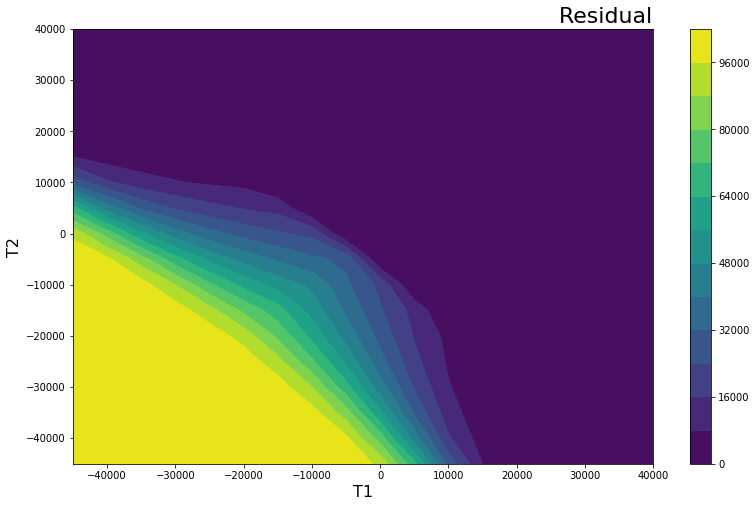

In [19]:
plt.figure(figsize=(13, 8))
plt.title('Residual', fontsize=22, loc='right')
plt.xlabel('T1', fontsize=16)
plt.ylabel('T2', fontsize=16)
plt.contourf(res[0], res[1], res[2], levels=15)
plt.colorbar()
plt.show()

## Results

In [9]:
T1 = 10000
T2 = 10001
AUDIO = filter_audio(audio_blurred, T1=T1, T2=T2)

In [10]:
print('Difference between origin audio and denoised with optimal parameters: {0}'.format(np.linalg.norm(audio - AUDIO)))

Difference between origin audio and denoised with optimal parameters: 980048.5182613909


In [11]:
print('Difference between origin audio and noised audio : {0}'.format(np.linalg.norm(audio - audio_blurred)))
print('Difference betweeb origin audio and denoised audion with non-optimal parameters : {0}'.format(np.linalg.norm(audio - audio_1)))

Difference between origin audio and noised audio : 1743888.3672036196
Difference betweeb origin audio and denoised audion with non-optimal parameters : 1300422.8143450618


In [12]:
k = 1000

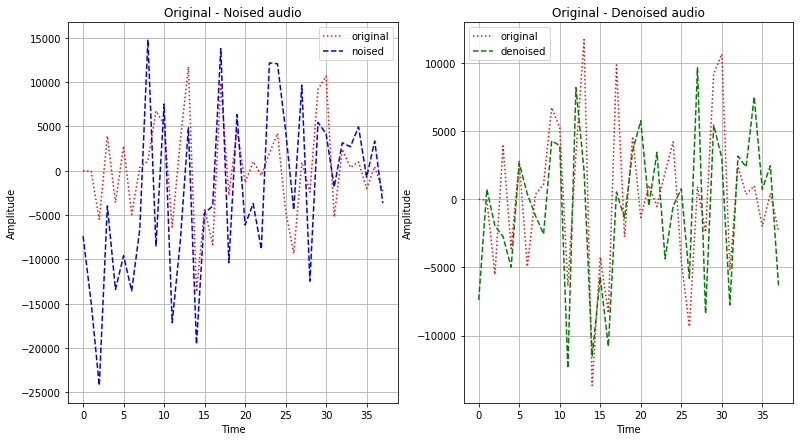

In [13]:
plt.figure(figsize=(13, 7))

plt.subplot(121)
plt.plot(audio[::k], ':r', label='original')
plt.plot(audio_blurred[::k], '--b', label='noised')
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Original - Noised audio")
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(audio[::k], ':r', label='original')
plt.plot(AUDIO[::k], '--g', label='denoised')
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Original - Denoised audio")
plt.grid()
plt.legend()
plt.show()

plt.show()

### Original audio

In [14]:
Audio(audio, rate=rate)

### Noised audio

In [15]:
Audio(audio_blurred, rate=rate)

### Denoised audio

In [16]:
Audio(AUDIO, rate=rate)